In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
ocean_discord = pd.read_csv('data/oceandiscord.csv')
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'].astype(str).str[:10]) #just days
# Group by 'Date' and aggregate counts of messages, attachments, and reactions
daily_activity = ocean_discord.groupby('Date').agg({
    'Attachments': 'count',       # Count of attachments
}).reset_index()

daily_activity = daily_activity[['Date', 'Attachments']]


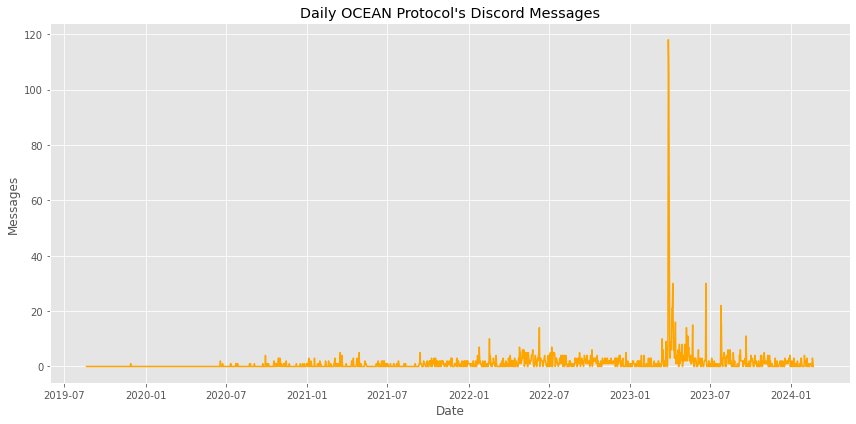

In [3]:
df1 = daily_activity.set_index('Date').Attachments

plt.figure(figsize=(12,6))
plt.plot(df1, linewidth=1.5, color='orange')
plt.title("Daily OCEAN Protocol's Discord Messages")
plt.xlabel('Date')
plt.ylabel('Messages')
plt.tight_layout()
plt.show()

In [4]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('The timeseries is Stationary' if p_value < 0.05 else 'The timeseries is Non-Stationary')

check_stationarity(df1)

ADF Statistic: -7.5538278159964305
p-value: 3.137508636286539e-11
The timeseries is Stationary


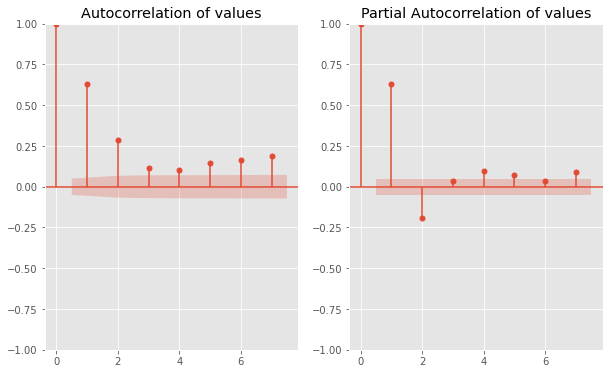

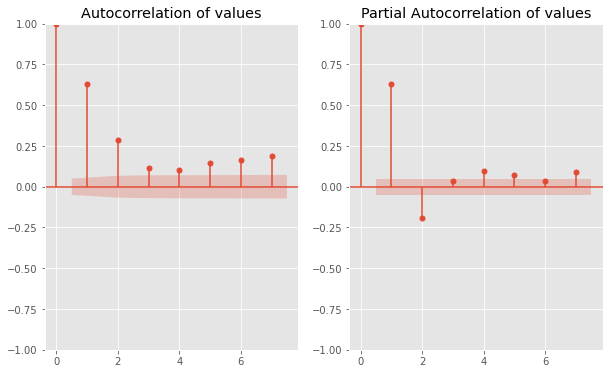

In [5]:
l = 7
_, ax = plt.subplots(1,2, figsize = (10,6))
plot_acf( df1, lags=l, ax = ax[0], title = 'Autocorrelation of values')
plot_pacf(df1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of values')

In [6]:
import itertools
ps = range(0, 4) # by partial autocorr
ds = range(0, 1)
qs = range(0, 2) # by autocorr



s = 365 # Assuming we have daily seasonality 
parameters = itertools.product(ps, ds, qs, [0], [0], [0], [s])
parameters_list = list(parameters)
print(len(parameters_list))

8


In [8]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        # 'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        # 'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        # 'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

In [9]:
%%time
x = df1
list_param = []
list_res   = []
list_time  = []
list_pred  = []
import gc
import time
n = len(x)
n1 = 365

for p in parameters_list:
    t1 = time.time()
    list_res1 = list()
    list_pred1 = list()
    # train-valid split
    for k in range(1):
        train, valid = x[:-n1], x[-n1:]
        
        # train
        try:
            model_arima = SARIMAX(train, order=(p[0],p[1],p[2]), seasonal_order=(p[3],p[4],p[5],p[6]))
            model_arima = model_arima.fit(disp=-1)
        except Exception as e:
            print(p, e)
            break
            
        # predict
        pred = model_arima.predict(start = 0, end = n - 1)
        pred = pred[-n1:]
        list_pred1 += list(pred)
        
        # evaluate
        res = ts_metrics(valid, pred)
        list_res1.append(res)
        
        del model_arima
        gc.collect()
        
        # break
        
    # collect
    if len(list_pred1) > 0:
        list_pred.append(list_pred1)
        list_res.append(pd.DataFrame(list_res1).mean())
        list_time.append({'time':time.time() - t1})
        list_param.append(p)

Wall time: 2.79 s


In [10]:
# results
df_out = pd.concat([
    pd.DataFrame(list_param, columns = ['p','d','q','P','D','Q','S']),
    pd.DataFrame(list_res),
    pd.DataFrame(list_time),
], axis = 1).sort_values('mae')

df_out.drop(['P', 'D', 'Q', 'S', 'time'], axis=1,inplace=True)
df_out.reset_index(inplace = True)
del df_out['index']
df_out[:10]

,p,d,q,mae,mse
0,3,0,1,2.720347,89.964995
1,2,0,1,2.721151,89.975661
2,1,0,1,2.737739,90.199481
3,0,0,0,2.895890,93.553425
4,1,0,0,2.895890,93.553425
5,2,0,0,2.895890,93.553425
6,0,0,1,2.896367,93.553507
7,3,0,0,2.898892,93.545746


In [11]:
model = SARIMAX(x, order=(3, 0, 1), seasonal_order=(0, 0, 0, 365))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Attachments   No. Observations:                 1537
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -4130.843
Date:                Mon, 11 Mar 2024   AIC                           8271.686
Time:                        20:24:51   BIC                           8298.373
Sample:                             0   HQIC                          8281.616
                               - 1537                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6549      0.020     83.676      0.000       1.616       1.694
ar.L2         -0.9145      0.024    -37.622      0.000      -0.962      -0.867
ar.L3          0.2452      0.020     12.087      0.000       0.205       0.285
ma.L1         -0.9086      0.020    -46.468      0.000      -0.947      -0.870
sigma2        12.6381      0.031    411.095      0.000      12.578      12.698
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):          26651494.01
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):              62.60   Skew:                            20.80
Prob(H) (two-sided):                  0.00   Kurtosis:                       646.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

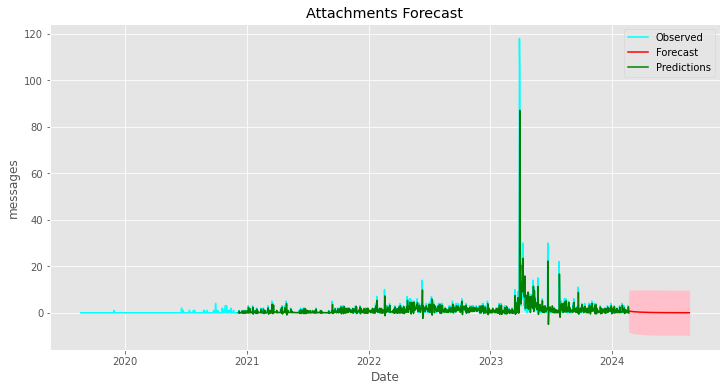

In [13]:

forecast_periods = 183 # Forecast the next 365 days
forecast = fitted_model.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
predictions = fitted_model.predict(start=365, steps=365)
 
start_date = ocean_discord['Date'].max()

forecast_mean.index =  pd.date_range(start=start_date, periods=forecast_periods, freq='D')
forecast_ci.index =  pd.date_range(start=start_date, periods=forecast_periods, freq='D')
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df1, label='Observed', color='cyan')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.plot(predictions, label='Predictions', color='green')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Attachments Forecast")
plt.xlabel("Date")
plt.ylabel("messages")
plt.legend()
plt.show()

In [14]:
forecast_mean

2024-02-20   -0.132823
2024-02-21    0.270576
2024-02-22    0.569243
2024-02-23    0.662041
2024-02-24    0.641401
                ...   
2024-08-16    0.007000
2024-08-17    0.006824
2024-08-18    0.006652
2024-08-19    0.006485
2024-08-20    0.006322
Freq: D, Name: predicted_mean, Length: 183, dtype: float64